# Spectral Clustering

**Spectral Clustering** is a powerful clustering method that works by:

- Treating your data as a **graph**, where each point is a node.
- Defining a **similarity matrix** (an affinity matrix) to connect nodes that are "close enough" or similar.
- Using the **eigenvectors** of the Laplacian of this graph to embed the data in a low-dimensional space.
- Running a simpler clustering method (like K-Means) in this new space.

Unlike K-Means, Spectral Clustering does **not** assume clusters are convex or spherical — so it can find more flexible shapes, like moons or rings. It’s a good choice when your data is not well-separated in simple Euclidean terms but *is* connected in a graph sense.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

plt.style.use('dark_background')

# Make data

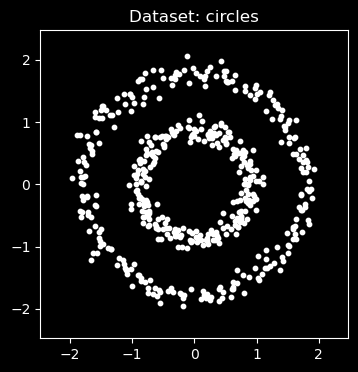

In [2]:
from sklearn.datasets import make_blobs, make_classification, make_moons, make_circles

dataset_type = 'circles'  # try: blobs, classification, moons, circles, anisotropic, varied

if dataset_type == 'blobs':
    X1, _ = make_blobs(
        n_samples=500,
        centers=3,
        cluster_std=3,
        random_state=42
    )

elif dataset_type == 'classification':
    X1, _ = make_classification(
        n_samples=120,
        n_features=2,
        n_redundant=0,
        n_clusters_per_class=1,
        n_classes=3,
        class_sep=2,
        random_state=42
    )

elif dataset_type == 'moons':
    from sklearn.datasets import make_moons
    X1, _ = make_moons(
        n_samples=120,
        noise=0.1,
        random_state=42
    )

elif dataset_type == 'circles':
    from sklearn.datasets import make_circles
    X1, _ = make_circles(
        n_samples=500,
        noise=0.05,
        factor=0.5,
        random_state=42
    )

elif dataset_type == 'anisotropic':
    X1, _ = make_blobs(
        n_samples=120,
        centers=3,
        cluster_std=1,
        random_state=42
    )
    # Apply an anisotropic linear transformation
    transformation = [[0.6, -0.6], [-0.4, 0.8]]
    X1 = X1.dot(transformation)

elif dataset_type == 'varied':
    X1, _ = make_blobs(
        n_samples=120,
        centers=[[-5, -5], [0, 0], [5, 5]],
        cluster_std=[1.0, 2.5, 0.5],
        random_state=42
    )

else:
    raise ValueError("Unknown dataset_type")

# Normalize and add optional noise
n_noise = 0
X1 -= np.mean(X1, axis=0)
MAX = np.max(np.abs(X1))
X2 = np.random.uniform(-MAX, MAX, size=(n_noise, 2))

X = np.concatenate((X1, X2), axis=0)
X -= np.mean(X, axis=0)
X /= np.std(X)
MAX = np.max(np.abs(X)) * 1.2

# Plot
%matplotlib inline

plt.figure(figsize=(4, 4))
plt.scatter(X[:, 0], X[:, 1], c='w', s=10)
plt.xlim(-MAX, MAX)
plt.ylim(-MAX, MAX)
plt.gca().set_aspect('equal')
plt.title(f"Dataset: {dataset_type}")
plt.show()

# Manual Spectral Clustering Step by Step

To really understand how Spectral Clustering works, you can implement it *manually*:

1. **Build the similarity matrix**  
   - Use a simple custom RBF:  
     $$
     S_{ij} = \frac{1}{1 + \text{dist}(x_i, x_j)}
     $$

2. **Construct the degree matrix**  
   - Diagonal matrix where each entry is the sum of similarities for a point.

3. **Compute the unnormalized graph Laplacian**  
   - $$
   L = D - S
   $$

4. **Compute the eigenvectors** of the Laplacian.

5. **Embed** your data in the space of the first *k* eigenvectors.

6. **Run K-Means** on this embedding.

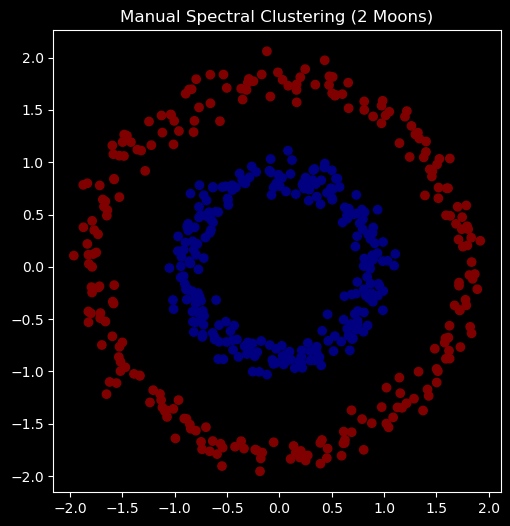

In [6]:
from sklearn.cluster import KMeans

# --------------------------------
# Step 1: Build custom similarity matrix
# --------------------------------
from scipy.spatial.distance import cdist

sigma = 0.2
distances = cdist(X, X)
S = np.exp(-distances**2 / (2 * sigma**2))

# --------------------------------
# Step 2: Degree matrix
# --------------------------------
D = np.diag(S.sum(axis=1))

# --------------------------------
# Step 3: Unnormalized graph Laplacian
# --------------------------------
L = D - S

# --------------------------------
# Step 4: Compute eigenvectors
# --------------------------------
eigvals, eigvecs = np.linalg.eigh(L)  # For symmetric L

# Sort eigenvectors by ascending eigenvalues
idx = np.argsort(eigvals)
eigvecs = eigvecs[:, idx]

# --------------------------------
# Step 5: Embed data using first k eigenvectors (skip the first one)
# --------------------------------
k = 2
embedding = eigvecs[:, 1:k+1]  # skip the trivial first eigenvector

# --------------------------------
# Step 6: K-Means on the embedding
# --------------------------------
labels = KMeans(n_clusters=k, random_state=0).fit_predict(embedding)

# --------------------------------
# Plot results
# --------------------------------
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='jet')
plt.title("Manual Spectral Clustering (2 Moons)")
plt.gca().set_aspect('equal')
plt.show()

# Spectral Clustering in `sklearn`

`sklearn.cluster.SpectralClustering` implements spectral clustering — a method that finds clusters using the **eigenvectors** of a graph Laplacian built from your data.

Instead of clustering directly in the original space, spectral clustering:
1. **Builds a similarity (affinity) matrix** that represents how similar or connected each pair of points is.
2. **Constructs a graph Laplacian** from this matrix and computes its eigenvectors.
3. **Embeds the data** in a lower-dimensional space using these eigenvectors.
4. **Runs a standard clusterer** (typically K-Means) on this embedding.

## Key Arguments

- **`n_clusters`**  
  The number of clusters you want. Required.

- **`affinity`**  
  Controls how the similarity graph is built:
  - `'rbf'` → fully connected similarity graph using a Gaussian (RBF) kernel.
  - `'nearest_neighbors'` → graph connects each point to its *k* nearest neighbors.
  - `'precomputed'` → use your own affinity matrix.
  - `'precomputed_nearest_neighbors'` → precompute nearest neighbor graph externally.

- **`n_neighbors`**  
  If `affinity='nearest_neighbors'`, sets how many neighbors to connect each point to.

- **`gamma`**  
  Only used for `'rbf'` affinity. Controls the width of the RBF kernel — higher gamma means tighter connections.

- **`assign_labels`**  
  Determines how the final clusters are assigned in the spectral embedding:
  - `'kmeans'` (default): K-Means on the embedding.
  - `'discretize'`: A more direct approach that tries to discretize the embedding (can be more accurate but slower).

## **When to use Spectral Clustering?**

Spectral Clustering works best when:
- Your clusters are **non-convex** (like circles or moons).
- You want to discover groups based on a graph view of similarity, not just distance.
- The dataset isn’t huge (it scales poorly to very large datasets because eigenvector decomposition is costly).


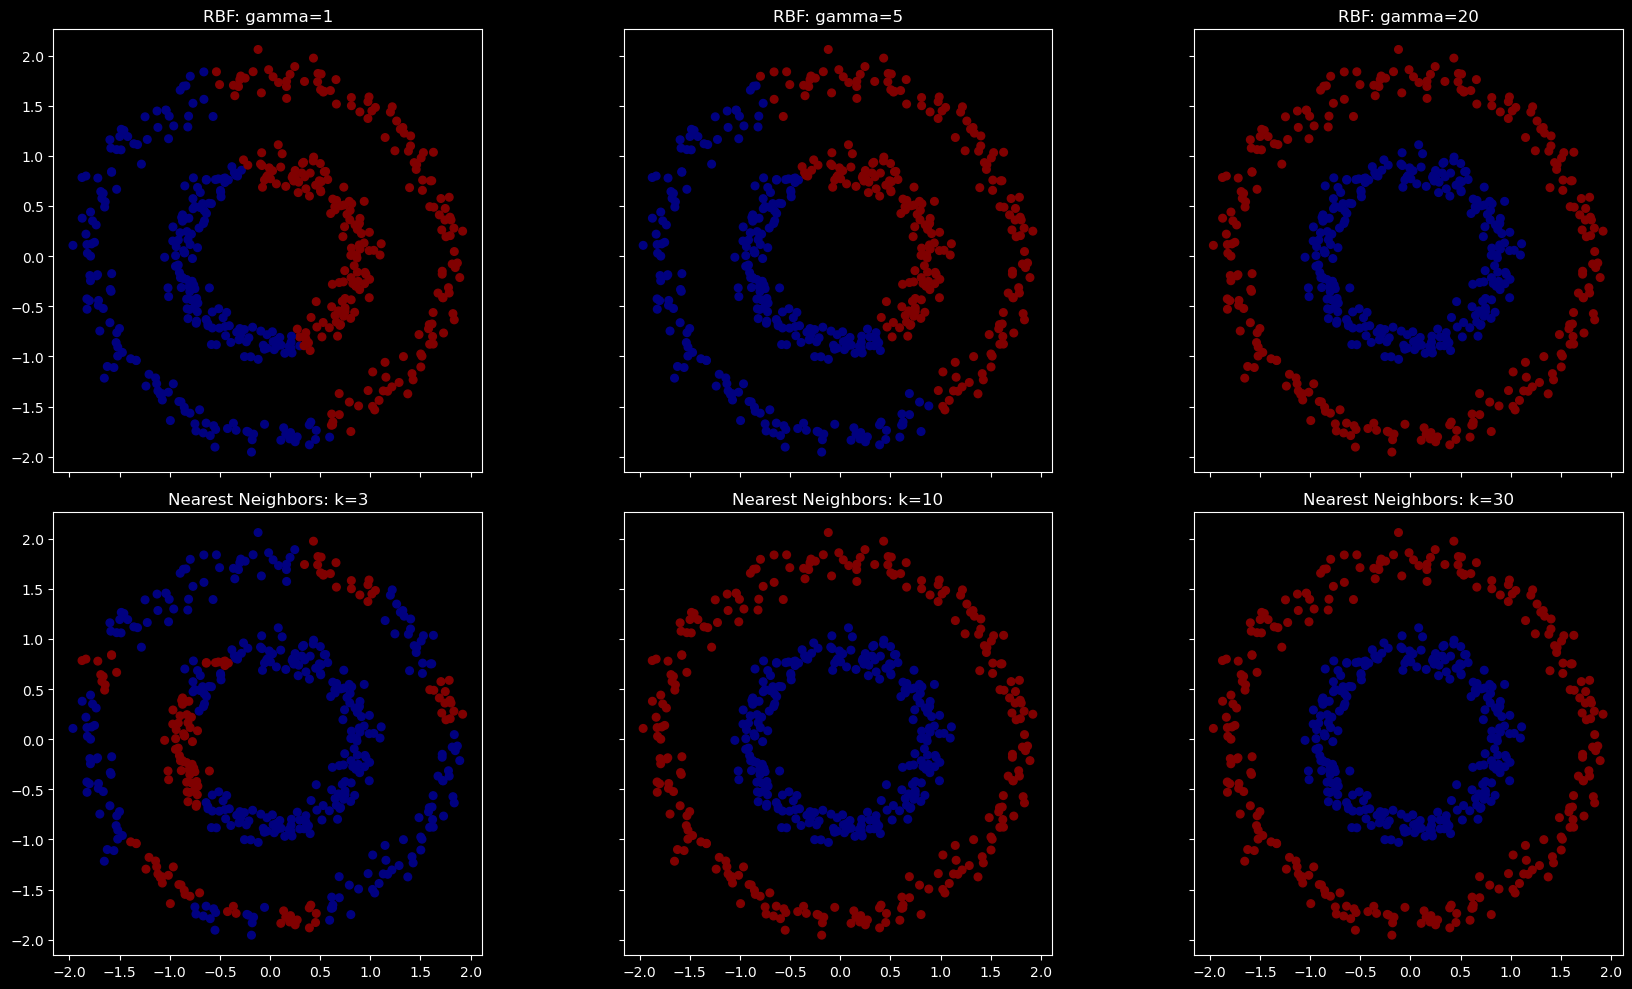

In [12]:
from sklearn.cluster import SpectralClustering

cmap = 'jet'
N_CLUSTERS = 2

# --------------------------------
# RBF models with different gamma
# --------------------------------
model_rbf_1 = SpectralClustering(
    n_clusters=N_CLUSTERS,
    affinity='rbf',
    gamma=1,
    assign_labels='kmeans',
    random_state=0
)
labels_rbf_1 = model_rbf_1.fit_predict(X)

model_rbf_5 = SpectralClustering(
    n_clusters=N_CLUSTERS,
    affinity='rbf',
    gamma=5,
    assign_labels='kmeans',
    random_state=0
)
labels_rbf_5 = model_rbf_5.fit_predict(X)

model_rbf_20 = SpectralClustering(
    n_clusters=N_CLUSTERS,
    affinity='rbf',
    gamma=20,
    assign_labels='kmeans',
    random_state=0
)
labels_rbf_20 = model_rbf_20.fit_predict(X)

# --------------------------------
# Nearest neighbors models with different k
# --------------------------------
model_nn_3 = SpectralClustering(
    n_clusters=N_CLUSTERS,
    affinity='nearest_neighbors',
    n_neighbors=3,
    assign_labels='kmeans',
    random_state=0
)
labels_nn_3 = model_nn_3.fit_predict(X)

model_nn_10 = SpectralClustering(
    n_clusters=N_CLUSTERS,
    affinity='nearest_neighbors',
    n_neighbors=10,
    assign_labels='kmeans',
    random_state=0
)
labels_nn_10 = model_nn_10.fit_predict(X)

model_nn_30 = SpectralClustering(
    n_clusters=N_CLUSTERS,
    affinity='nearest_neighbors',
    n_neighbors=10,
    assign_labels='kmeans',
    random_state=0
)
labels_nn_30 = model_nn_30.fit_predict(X)

# --------------------------------
# Plot grid
# --------------------------------
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True, sharey=True)

axes[0, 0].scatter(X[:, 0], X[:, 1], c=labels_rbf_1, cmap=cmap, s=30)
axes[0, 0].set_title("RBF: gamma=1")

axes[0, 1].scatter(X[:, 0], X[:, 1], c=labels_rbf_5, cmap=cmap, s=30)
axes[0, 1].set_title("RBF: gamma=5")

axes[0, 2].scatter(X[:, 0], X[:, 1], c=labels_rbf_20, cmap=cmap, s=30)
axes[0, 2].set_title("RBF: gamma=20")

axes[1, 0].scatter(X[:, 0], X[:, 1], c=labels_nn_3, cmap=cmap, s=30)
axes[1, 0].set_title("Nearest Neighbors: k=3")

axes[1, 1].scatter(X[:, 0], X[:, 1], c=labels_nn_10, cmap=cmap, s=30)
axes[1, 1].set_title("Nearest Neighbors: k=10")

axes[1, 2].scatter(X[:, 0], X[:, 1], c=labels_nn_30, cmap=cmap, s=30)
axes[1, 2].set_title("Nearest Neighbors: k=30")

# Fix aspect ratio
for ax in axes.flat:
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()